In [1]:
# Install a kaggle package to download the dataset

! pip install -q kaggle

! pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105119 sha256=b6160df2b685f3396227f98f8226b34e865fb144f20864a15c6f61e14525a0f1
  Stored in directory: /root/.cache/pip/wheels/d7/54/06/8a8f40cb39536605feb9acaacd0237a95eba39e5065e6392f4
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.14
    Uninstalling kaggle-1.6.14:
      Successfully uninstalled kaggle-1.6.14


## Import the dataset from Kaggle.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ghezalkhalida","key":"522dd6d38fb4f64df9378c8c3015e521"}'}

In [3]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [06:35<00:00, 22.9MB/s]
100% 6.31G/6.31G [06:35<00:00, 17.1MB/s]


In [ ]:
#! kaggle competitions download -c histopathologic-cancer-detection

In [9]:
# Unzip and load the dataset onto your current directory

import zipfile

zip = zipfile.ZipFile('/content/histopathologic-cancer-detection.zip')

zip.extractall()

## The GitHub Repository Link:

https://github.com/khalidakhaldi/Histopathologic-Cancer-Detection

# Histopathologic Cancer Detection Project

The aim of this project is to develop an algorithm that identifies metastatic tissues in histopathologic scans of lymph node sections using a deep learning technique—Convolutional Neural Network (CNN). Our goal is to classify cancerous tissues into two categories: Malignant (labeled as “1”) and Benign (labeled as “0”). This project seeks to understand the cancer detection process using a provided dataset, which consists of numerous small pathology images labeled as “1” or “0”.

### Check the number of images in the train and test folders:

In [10]:
import os
import glob

# Define the paths to the train and test folders
train_folder = '/content/train'
test_folder = '/content/test'

# Count the number of .tif images in the train folder
train_images = glob.glob(os.path.join(train_folder, '*.tif'))
num_train_images = len(train_images)

# Count the number of .tif images in the test folder
test_images = glob.glob(os.path.join(test_folder, '*.tif'))
num_test_images = len(test_images)

print(f'Number of images in the train folder: {num_train_images}')
print(f'Number of images in the test folder: {num_test_images}')

Number of images in the train folder: 220025
Number of images in the test folder: 57458


### Import Libraries

In [11]:
from numpy.random import seed


import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
from numpy.random import seed
import tensorflow as tf

# Set the random seed for NumPy
seed(101)

# Set the random seed for TensorFlow
tf.random.set_seed(101)

### Loading and Previewing Dataset from CSV File

In [22]:
path = "/content/train_labels.csv"
data = pd.read_csv(path, dtype=str)
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [13]:
data.shape

(220025, 2)

In [14]:
data['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

### Visualize the images for two classes (tumor == 1 and no tumor == 0)

In [114]:
def draw_category_images_from_dir(dir_path, col_name, figure_cols, df):
    """
    Displays a grid of images sampled from each category in a dataframe column, reading images from a directory.

    Parameters:
    dir_path (str): The path to the directory containing images.
    col_name (str): The name of the column containing categories.
    figure_cols (int): The number of columns in the output figure (sample size per category).
    df (DataFrame): The dataframe containing image information.
    """
    categories = df[col_name].unique()
    num_categories = len(categories)
    fig, axes = plt.subplots(nrows=num_categories, ncols=figure_cols, figsize=(4 * figure_cols, 4 * num_categories))

    for i, cat in enumerate(categories):
        sample = df[df[col_name] == cat].sample(figure_cols)
        for j in range(figure_cols):
            image_id = sample.iloc[j]['id']
            image_file = os.path.join(dir_path, f"{image_id}.tif")
            if os.path.exists(image_file):
                image = cv2.imread(image_file, cv2.IMREAD_COLOR)
                axes[i, j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(cat, fontsize=16)
                axes[i, j].axis('off')
            else:
                print(f"Image file {image_file} not found.")

    plt.tight_layout()
    plt.show()

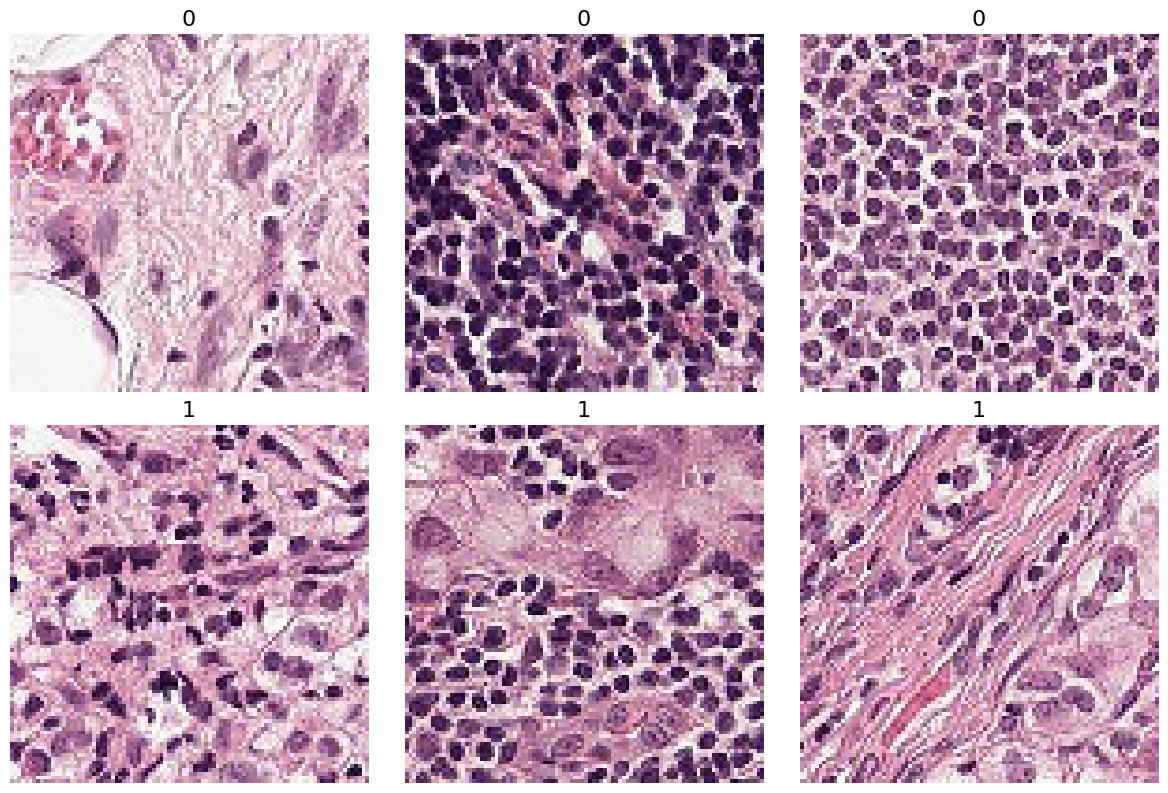

In [62]:
path_images = "/content/train"
draw_category_images_from_dir(path_images, 'label', 3, data)


### Check if data are balanced

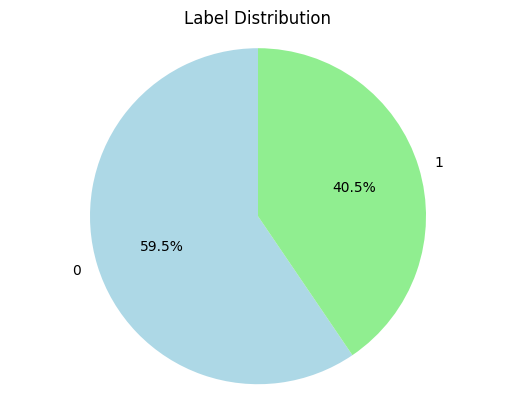

In [17]:
# Calculate label counts and percentages
label_counts = data['label'].value_counts()
label_percentages = label_counts / len(data) * 100

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(label_percentages, labels=label_percentages.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title(f'Label Distribution')
plt.show()

The dataset exhibits an approximately balanced class distribution, with Class 0 representing approximately 59.5% of the data and Class 1 representing approximately 40.5%.

## Appending File Extension to DataFrame Column 'id

In [23]:
#
data['id'] = data['id'].apply(lambda x: x + '.tif')
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


## Split the Data

In [25]:

train_df, val_df = train_test_split(data, test_size=0.1, random_state=1, stratify=data.label)

# Getting the shape of train_df and val_df
train_shape = train_df.shape
val_shape = val_df.shape

print("Train DataFrame Shape:", train_df.shape)
print("Validation DataFrame Shape:", val_df.shape)

Train DataFrame Shape: (198022, 2)
Validation DataFrame Shape: (22003, 2)




The training DataFrame contains 198,022 rows and 2 columns, while the validation DataFrame comprises 22,003 rows and 2 columns. This suggests a larger dataset for training compared to validation, indicating a standard practice in machine learning model development.

### Setting up Image Data Generators for Training and Validation

In [26]:
BATCH_SIZE = 64
train_path  = '/content/train'
data['label'] = data['label'].astype(str)
# Define ImageDataGenerator with rescaling
datagen = ImageDataGenerator(rescale=1.0/255)

train_loader = datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

valid_loader = datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
        class_mode = 'categorical',
    target_size = (96,96)
)

Found 198022 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


The code sets up image data generators for training and validation. It rescales pixel values to a range between 0 and 1. Images are loaded from the '/content/train' directory based on DataFrame entries, with labels converted to categorical format. Each batch contains 64 samples, and images are resized to a target size of 96x96 pixels. Training and validation data are shuffled and returned in batches.

## Calculating Training and Validation Steps

In [27]:
train_steps = len(train_loader)
val_steps = len(valid_loader)

print(train_steps)
print(val_steps)

3095
344


# The first base_model

In [28]:
#base_model = tf.keras.applications.ResNet50(
 #   input_shape=(96, 96, 3),
#    include_top=False,
#    weights='imagenet'
#)

#base_model.trainable = False

#base_model.summary()

**I trained the model using the first base model, but the training accuracy wasn't satisfactory, and it took a long time**

# The second base model

In [29]:


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

base_model.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU

## Add custom layers on top of the base model:

In [30]:


np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    base_model,  # Using the base model defined earlier
    BatchNormalization(),
    Flatten(),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 batch_normalization (Batch  (None, 3, 3, 1280)        5120      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 8)                 92168     
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 3

## **Why I Used This CNN Architecture::**

Using a pre-trained base model like MobileNetV2 saves time by leveraging features learned from ImageNet, avoiding the need to retrain the entire model for our dataset. When excluding the final classification layers with include_top=False, custom layers can be added to suit our dataset. By freezing the base model's weights (base_model.trainable = False), we maintain stability in learned features, which is helpful for limited data or computational resources and reduces overfitting. Custom layers on top of the base model allow fine-tuning for our dataset's needs, with trainable weights to adjust during training. This combination supports transfer learning, transferring knowledge from tasks like ImageNet classification to our  dataset while adapting to its specifics.

## Model Compilation with Adam Optimizer

In [31]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()])

## Model Training

In [32]:
%%time

h1 = cnn.fit(
    x = train_loader,
    steps_per_epoch = train_steps,
    epochs = 50,
    validation_data = valid_loader,
    validation_steps = val_steps,
    verbose = 1
)

Epoch 1/50
3095/3095 [==============================] - 447s 140ms/step - loss: 0.5461 - accuracy: 0.7241 - auc: 0.7942 - val_loss: 0.3968 - val_accuracy: 0.8479 - val_auc: 0.9305
Epoch 2/50
3095/3095 [==============================] - 345s 112ms/step - loss: 0.4872 - accuracy: 0.7501 - auc: 0.8429 - val_loss: 0.3493 - val_accuracy: 0.8567 - val_auc: 0.9379
Epoch 3/50
3095/3095 [==============================] - 333s 108ms/step - loss: 0.4629 - accuracy: 0.7636 - auc: 0.8596 - val_loss: 0.3394 - val_accuracy: 0.8633 - val_auc: 0.9423
Epoch 4/50
3095/3095 [==============================] - 329s 106ms/step - loss: 0.4525 - accuracy: 0.7676 - auc: 0.8656 - val_loss: 0.3263 - val_accuracy: 0.8626 - val_auc: 0.9429
Epoch 5/50
3095/3095 [==============================] - 329s 106ms/step - loss: 0.4457 - accuracy: 0.7698 - auc: 0.8690 - val_loss: 0.3211 - val_accuracy: 0.8675 - val_auc: 0.9450
Epoch 6/50
3095/3095 [==============================] - 318s 103ms/step - loss: 0.4437 - accuracy: 0

In [34]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

## Visualize the model's performance in terms of loss, accuracy, and AUC.

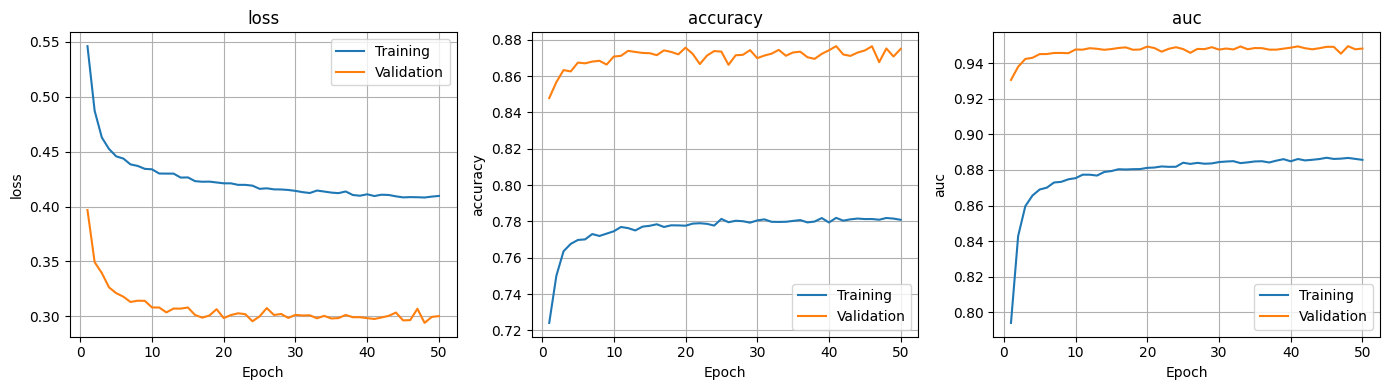

In [35]:
history = merge_history([h1])
vis_training(history)

## Discussion

The model achieves a training accuracy of 0.78 and an AUC of 0.89. Meanwhile, the validation accuracy is 0.88 with an AUC of 0.95. To improve performance, I need to tune hyperparameters such as the learning rate and number of epochs."

### Tuning parameters.

In [43]:
from tensorflow.keras import backend as k
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
base_model.trainable = True
k.set_value(cnn.optimizer.learning_rate, 0.01)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [44]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 batch_normalization (Batch  (None, 3, 3, 1280)        5120      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 8)                 92168     
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 3

#### Training 2

In [45]:
%%time

h2 = cnn.fit(
    x = train_loader,
    steps_per_epoch = train_steps,
    epochs = 20,
    validation_data = valid_loader,
    validation_steps = val_steps,
    verbose = 1
)

Epoch 1/20
3095/3095 [==============================] - 477s 145ms/step - loss: 0.3529 - accuracy: 0.8165 - auc_3: 0.9191 - val_loss: 0.1756 - val_accuracy: 0.9359 - val_auc_3: 0.9831
Epoch 2/20
3095/3095 [==============================] - 451s 146ms/step - loss: 0.3241 - accuracy: 0.8274 - auc_3: 0.9297 - val_loss: 0.1296 - val_accuracy: 0.9551 - val_auc_3: 0.9903
Epoch 3/20
3095/3095 [==============================] - 441s 143ms/step - loss: 0.3083 - accuracy: 0.8356 - auc_3: 0.9360 - val_loss: 0.1459 - val_accuracy: 0.9479 - val_auc_3: 0.9864
Epoch 4/20
3095/3095 [==============================] - 439s 142ms/step - loss: 0.3003 - accuracy: 0.8452 - auc_3: 0.9402 - val_loss: 0.1261 - val_accuracy: 0.9543 - val_auc_3: 0.9898
Epoch 5/20
3095/3095 [==============================] - 442s 143ms/step - loss: 0.2947 - accuracy: 0.8490 - auc_3: 0.9423 - val_loss: 0.1685 - val_accuracy: 0.9311 - val_auc_3: 0.9827
Epoch 6/20
3095/3095 [==============================] - 482s 156ms/step - loss: 

These lines of code update the history object of a trained model by assigning the training and validation AUC (Area Under the Curve) metrics to new keys 'auc' and 'val_auc', respectively. The first line assigns the values of the 'auc_1' metric, representing the training AUC, to the 'auc' key, while the second line does the same for the 'val_auc_1' metric, representing the validation AUC, to the 'val_auc' key. This modification allows for easier access and interpretation of these metrics during analysis or visualization of the training history.

In [48]:
print(h1.history.keys())
print(h2.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])
dict_keys(['loss', 'accuracy', 'auc_3', 'val_loss', 'val_accuracy', 'val_auc_3'])


In [49]:
h2.history['auc'] = h2.history['auc_3']
h2.history['val_auc'] = h2.history['val_auc_3']

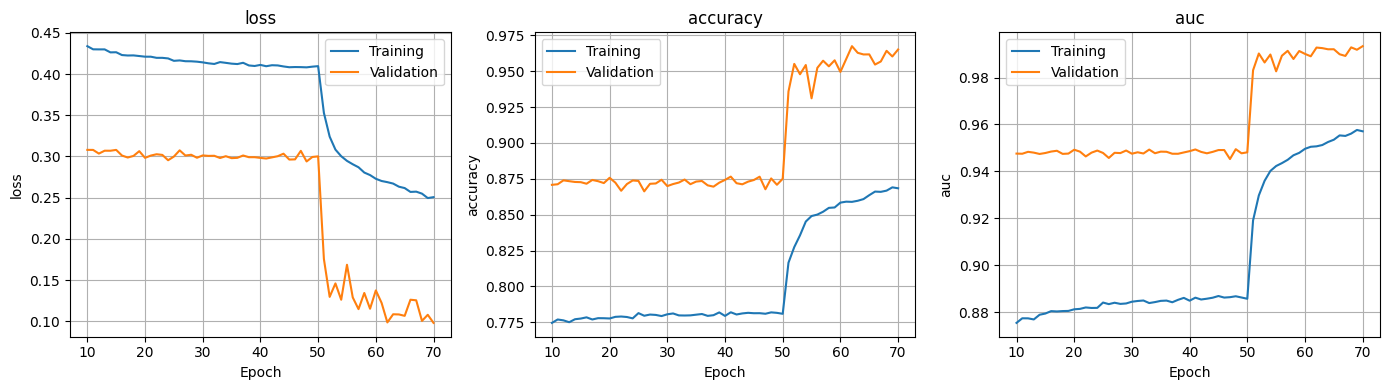

In [50]:
history = merge_history([h1, h2])
vis_training(history, start=10)

### Training 3

In [51]:
%%time

h3 = cnn.fit(
    x = train_loader,
    steps_per_epoch = train_steps,
    epochs = 20,
    validation_data = valid_loader,
    validation_steps = val_steps,
    verbose = 1
)

Epoch 1/20
3095/3095 [==============================] - 404s 131ms/step - loss: 0.2470 - accuracy: 0.8701 - auc_3: 0.9583 - val_loss: 0.1278 - val_accuracy: 0.9539 - val_auc_3: 0.9894
Epoch 2/20
3095/3095 [==============================] - 403s 130ms/step - loss: 0.2445 - accuracy: 0.8707 - auc_3: 0.9590 - val_loss: 0.1114 - val_accuracy: 0.9588 - val_auc_3: 0.9917
Epoch 3/20
3095/3095 [==============================] - 402s 130ms/step - loss: 0.2461 - accuracy: 0.8696 - auc_3: 0.9585 - val_loss: 0.1031 - val_accuracy: 0.9636 - val_auc_3: 0.9921
Epoch 4/20
3095/3095 [==============================] - 412s 133ms/step - loss: 0.2402 - accuracy: 0.8718 - auc_3: 0.9602 - val_loss: 0.1139 - val_accuracy: 0.9574 - val_auc_3: 0.9905
Epoch 5/20
3095/3095 [==============================] - 405s 131ms/step - loss: 0.2400 - accuracy: 0.8721 - auc_3: 0.9603 - val_loss: 0.1031 - val_accuracy: 0.9619 - val_auc_3: 0.9921
Epoch 6/20
3095/3095 [==============================] - 400s 129ms/step - loss: 

In [52]:
h3.history['auc'] = h3.history['auc_3']
h3.history['val_auc'] = h3.history['val_auc_3']

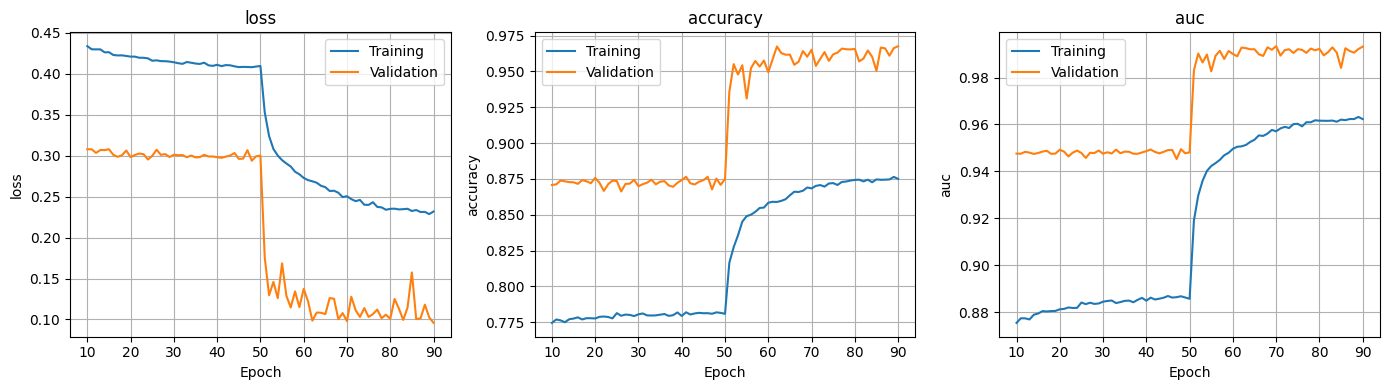

In [53]:
history = merge_history([h1, h2, h3])
vis_training(history, start=10)

# Discussion:

By tuning hyperparameters such as the learning rate to 0.00001 and decreasing the number of epochs to 20 in the second training, and then to 20 epochs in the third training, the model's performance improved. It achieved a training accuracy of 0.88 and an AUC of 0.9623. Additionally, the validation accuracy improved to 0.97 with an AUC of 0.99. I believe this represents a significant improvement in performance.

### Saving Model and History with Pickle

In [55]:
import pickle
cnn.save('/content/drive/MyDrive/cHCDv01.h5')
pickle.dump(history, open(f'HCDv01.pkl', 'wb'))

# Submission

In [56]:
test = pd.read_csv('/content/sample_submission.csv')

print('Test Set Size:', test.shape)

Test Set Size: (57458, 2)


In [57]:
test['filename'] = test.apply(lambda x: x['id'] + '.tif', axis=1)

In [58]:
test.head()

,id,label,filename
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [59]:
test_path = "/content/test"
print('Test Images:', len(os.listdir(test_path)))

Test Images: 57458


In [60]:
BATCH_SIZE = 64

test_datagen = ImageDataGenerator(rescale=1/255)

test_loader = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = test_path,
    x_col = 'filename',
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = None,
    target_size = (96,96)
)

Found 57458 validated image filenames.


In [61]:
test_probs = cnn.predict(test_loader)
print(test_probs.shape)

898/898 [==============================] - 123s 135ms/step
(57458, 2)


In [62]:
print(len(test_loader))

898


In [63]:
print(test_probs[:10,].round(2))

[[1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.98 0.02]
 [0.37 0.63]
 [1.   0.  ]
 [0.58 0.42]
 [1.   0.  ]
 [0.96 0.04]]


In [64]:
test_pred = np.argmax(test_probs, axis=1)
print(test_pred[:10])

[0 0 0 0 0 1 0 0 0 0]


## Prepare Submission

In [65]:
submission = pd.read_csv('/content/sample_submission.csv')
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [66]:
submission.label = test_probs[:,1]
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,3.081877e-05
1,95596b92e5066c5c52466c90b69ff089b39f2737,5.755292e-07
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,7.542266e-04
3,2c35657e312966e9294eac6841726ff3a748febf,1.431884e-04
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,1.713346e-02


In [69]:
submission.to_csv('submission.csv', header=True, index=False)

In [68]:
submission.to_csv('/content/drive/MyDrive/submission.csv', header=True, index=False)

# Conclusion:

The model achieved a private score of 0.9148 and a public score of 0.9448, which I believe is quite impressive. It correctly predicted 91% of the unseen test data. The approach of utilizing a base model and then adding custom layers to design the CNN architecture is indeed commendable.